# SIFT

In [1]:
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve 

(1024, 677, 3)


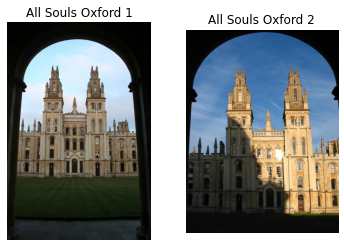

In [2]:
img1 = imread('all_souls_000002.jpg')
img2 = imread('all_souls_000015.jpg')
print(img1.shape)
plt.figure(figsize=(6,4))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('All Souls Oxford 1')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('All Souls Oxford 2')

plt.show()

## Step 1: Scale Space Extrema Detection

In [3]:
img = rgb2gray(img1)

In [4]:
def generate_octaves(im, num_octave, s, sigma):
    k = 2**(1/s)
    octaves = []
    for i in range(num_octave):
        octa = [im]
        for i in range(s):
            im = gaussian_filter(im, k*sigma)
            octa.append(im)
        octaves.append(octa)
        #Down sampling
        im = resize(im, (int(0.5*im.shape[0]), int(0.5*im.shape[1])))
    return octaves

In [5]:
sigma = 1
num_octaves = 4
s = 6
octaves = generate_octaves(img, num_octaves, s, sigma)

In [6]:
def generate_DOG_octaves(gaussian_octaves):
    DoG_octaves = []
    for octave in gaussian_octaves:
        DoG_oct = []
        for i in range(1, len(octave)):
            DoG_oct.append(octave[i] - octave[i-1])
        DoG_octaves.append(np.concatenate([o[:,:,np.newaxis] for o in DoG_oct], axis=2))
    return DoG_octaves

In [7]:
DoG_oct = generate_DOG_octaves(octaves)
print(DoG_oct[0].shape)
# s=6 images per set

(1024, 677, 6)


In [8]:
def get_candidate_keypoints(octa):
    keypoints = []
    octa[:,:,0] = 0
    octa[:,:,-1] = 0
    for i in range(1, len(octa)-2): # parcours les abscisses d'un élément de l'octave
        for j in range(1, len(octa[0])-2): # parcours les ordonées d'un élément de l'octave
            for k in range(1, len(octa[0][0])-2): # parcours les 6 éléments de l'octave
                patch = octa[i-1:i+2, j-1:j+2, k-1:k+2] # patch de pas 1
                if np.argmax(patch) == 13 or np.argmin(patch) == 13:
                    keypoints.append([i,j,k])
    return keypoints

In [9]:
octa = DoG_oct[0]
cand_kpts = get_candidate_keypoints(octa)

In [10]:
print(len(cand_kpts))

46557


## Step 2: Keypoint Localization

### Subpixel Localization

In [11]:
def Jacobian(D, x, y, s):
    dy = (D[x,y+1,s]-D[x,y-1,s])/2 
    dx = (D[x+1,y,s]-D[x-1,y,s])/2 
    ds = (D[x,y,s+1]-D[x,y,s-1])/2 # dérivée par rapport à s? Pourquoi?
    return np.array([dx, dy, ds])

def Hessian(D, x, y, s):
    dyy = D[x,y+1,s]-2*D[x,y,s]+D[x,y-1,s] 
    dxy = ((D[x+1,y+1,s]-D[x+1,y-1,s]) - (D[x-1,y+1,s]-D[x-1,y-1,s]))/4. 
    dys = ((D[x,y+1,s+1]-D[x,y-1,s+1]) - (D[x,y+1,s-1]-D[x,y-1,s-1]))/4. 
    dxx = D[x+1,y,s]-2*D[x,y,s]+D[x-1,y,s] 
    dxs = ((D[x+1,y,s+1]-D[x-1,y,s+1]) - (D[x+1,y,s-1]-D[x-1,y,s-1]))/4. 
    dss = D[x,y,s+1]-2*D[x,y,s]+D[x,y,s-1] 
    return np.array([[dxx, dxy, dxs], [dxy, dyy, dys], [dxs, dys, dss]])

In [12]:
def localize_keypoint(D, x, y, s):
    # Jacobian and Hessian
    J = Jacobian(D, x, y, s)
    H = Hessian(D, x, y, s)

    # Offset
    offset = -np.linalg.inv(H).dot(J)

    return offset, J, H[:2,:2], x, y, s

In [13]:
x, y, s = cand_kpts[0]
local_kpt = localize_keypoint(octa, x, y, s)
print(local_kpt)
# s indique maintenant pour une octave donnée, la position de l'image où le keypoint a été trouvé 

(array([ 0.44088918, -0.24577117,  0.20704262]), array([ 9.42183126e-05, -6.29764372e-05,  2.14879863e-04]), array([[-1.88983052e-04,  9.05874690e-06],
       [ 9.05874690e-06, -2.01910202e-04]]), 1, 3, 1)


In [55]:
def find_keypoints_for_DoG_octave(D, t_c, R_th):
    candidates = get_candidate_keypoints(D)
    keypoints = []

    for i, cand in enumerate(candidates):
        x, y, s = cand[0], cand[1], cand[2]
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

        contrast = D[x,y,s] + .5*J.dot(offset)
        if abs(contrast) >= t_c:
            w, v = np.linalg.eig(H)
            r = w[1]/w[0]
            R = (r+1)**2 / r
            if R <= R_th:
                kp = np.array([x, y, s]) + offset
                if kp[0] < D.shape[0] and kp[1] < D.shape[1]:
                    keypoints.append(kp)

    return np.array(keypoints)

In [56]:
dx_thres = 0.03
r = 10

keypoints = find_keypoints_for_DoG_octave(octa, dx_thres, r)
print(keypoints)
# s est légèrement transformé par l'offset

[[ 82.01071869 290.88049133   1.20588095]
 [ 82.9990563  353.71370935   1.20756662]
 [ 83.64543865 362.59351341   1.20734238]
 ...
 [728.66494474 177.22260441   1.1840829 ]
 [728.49430599 235.14588451   1.19544346]
 [729.14087603 399.38093632   1.24910823]]


In [57]:
print(keypoints.shape)
print(np.amax(keypoints[:,0]))
print(octa.shape[0])
print(octa.shape[1])

(1986, 3)
729.1408760305497
1024
677


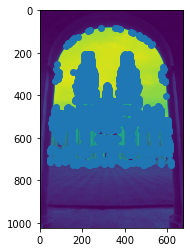

In [111]:
x_list = []
y_list = []
for kp in keypoints:
    y_list.append(int(kp[0]))
    x_list.append(int(kp[1]))   # ------- ATTENTION x, y sont en fait inversés
# print(kplist)
plt.imshow(img)
plt.plot(x_list,y_list, 'o')
plt.show()

In [59]:
def get_all_keypoints(DOG_octaves,dx_thres, r):
    kpts = []
    for D in DOG_octaves:
        kpts.append(find_keypoints_for_DoG_octave(D, dx_thres, r))
    return kpts

In [60]:
all_keypoints = get_all_keypoints(DoG_oct,dx_thres, r)

## Step 3: Orientation Assignement

In [131]:
def get_m_theta(L, x, y):
    # inversemanet de x, y
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi)*180/np.pi
    return m, theta

def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)

In [132]:
def neighborhood(img, x, y, size):
    # size is an even number
    n, p = img.shape
    N = size//2
    patch = img[max(y-N,0): min(y+N, n),max(x-N,0): min(x+N, p)]
    return patch

In [185]:
def gaussian(x,y,sigma):
    return (1/(2*np.pi*sigma**2))*np.exp(-(x**2+y**2)/(2*sigma**2))

def gaussian_filter(sigma):
    size = 2*np.ceil(3*sigma)+1
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = gaussian(x, y, sigma)
    return g/g.sum()

print(gaussian_filter(1)[0,0])

1.965191612403191e-05


In [134]:
def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)

In [194]:
def assign_orientation(kps, octave, num_bins=36):
    new_kps = []
    bin_width = 360//num_bins
    for kp in kps:
        x, y, s = int(kp[1]), int(kp[0]), kp[2]

        # weighted by its gradient magnitude and by a Gaussian-weighted circular window with a σ that is 1.5 times that of the scale of the keypoint
        sigma = abs(s)*1.5
        L = octave[:,:,int(s)]
        # hist = np.zeros(num_bins, dtype=np.float32)
        hist = np.zeros((num_bins,1))
        # patch = neighborhood(L, x, y, w)
        kernel = gaussian_filter(sigma)
        w = 16
        N = int(w//2)
        for i in range(-N, N+1):
            for j in range(-N, N+1):
                m, theta = get_m_theta(L, x+i, y+j)
                ind = quantize_orientation(theta, num_bins)
                hist[ind] += m

        grad, orient = np.amax(hist), np.argmax(hist)*bin_width
        new_kps.append(np.array([kp[1], kp[0], sigma, orient]))
    
    return np.array(new_kps) 

In [195]:
new_kps = assign_orientation(all_keypoints[0], octa, num_bins=36)

In [196]:
print(new_kps[0:6])
# print(np.where(new_kps[:,3] == 0))

[[290.88049133  82.01071869   1.80882142 260.        ]
 [353.71370935  82.9990563    1.81134992 270.        ]
 [362.59351341  83.64543865   1.81101357 270.        ]
 [377.05909448  85.71247824   1.81596212 100.        ]
 [235.96923634  94.33713432   1.80095839  60.        ]
 [229.79744429  96.23860627   1.81796713  60.        ]]


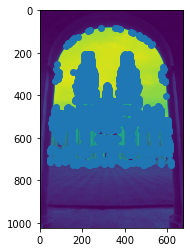

In [158]:
x,y = new_kps[:,0], new_kps[:,1]
plt.imshow(img)
plt.plot(x,y, 'o')
plt.show()

In [138]:
from numpy import *
from pylab import *

eps = 1e-9

def plotframes(frames, color='#00ff00', linewidth=1):
	# VL_PLOTFRAME  Plot feature frame
	#  VL_PLOTFRAME(FRAME) plots the frames FRAME.  Frames are attributed
	#  image regions (as, for example, extracted by a feature detector). A
	#  frame is a vector of D=2,3,..,6 real numbers, depending on its
	#  class. VL_PLOTFRAME() supports the following classes:
	#
	#   * POINTS
	#	 + FRAME(1:2)   coordinates
	#
	#   * CIRCLES
	#	 + FRAME(1:2)   center
	#	 + FRAME(3)	 radius
	#
	#   * ORIENTED CIRCLES
	#	 + FRAME(1:2)   center
	#	 + FRAME(3)	 radius
	#	 + FRAME(4)	 orientation
	#
	#   * ELLIPSES
	#	 + FRAME(1:2)   center
	#	 + FRAME(3:5)   S11, S12, S22 of x' inv(S) x = 1.
	#
	#   * ORIENTED ELLIPSES
	#	 + FRAME(1:2)   center
	#	 + FRAME(3:6)   A(:) of ELLIPSE = A UNIT_CIRCLE
	#
	#  H=VL_PLOTFRAME(...) returns the handle of the graphical object
	#  representing the frames.
	#
	#  VL_PLOTFRAME(FRAMES) where FRAMES is a matrix whose column are FRAME
	#  vectors plots all frames simultaneously. Using this call is much
	#  faster than calling VL_PLOTFRAME() for each frame.
	#
	#  VL_PLOTFRAME(FRAMES,...) passes any extra argument to the underlying
	#  plot function. The first optional argument can be a line
	#  specification string such as the one used by PLOT().
	#
	#  See also:: VL_HELP().
	
	# AUTORIGHTS
	# Copyright 2007 (c) Andrea Vedaldi and Brian Fulkerson
	# 
	# This file is part of VLFeat, available in the terms of the GNU
	# General Public License version 2.
	
	# number of vertices drawn for each frame
	np = 40
	

	# --------------------------------------------------------------------
	#										 Handle various frame classes
	# --------------------------------------------------------------------
	
	# if just a vector, make sure it is column
	if min(frames.shape) == 1:
		frames = frames[:]
	
	if frames.shape[0]>6 and frames.shape[1]<=6: # transpose
		frames=transpose(frames,(1,0))

	[D, K] = frames.shape
	zero_dimensional = D == 2
	
	# just points?
	if zero_dimensional:
		h = plot(frames[0, :], frames[1, :], '.', color=color)
		return
	
	# reduce all other cases to ellipses/oriented ellipses 	
	frames = frame2oell(frames)	
	do_arrows = (D == 4 or D == 6)
	
	# --------------------------------------------------------------------
	#																 Draw
	# --------------------------------------------------------------------
	
	K = frames.shape[1]
	thr = linspace(0, 2 * pi, np) ;
	
	# allx and ally are nan separated lists of the vertices describing the
	# boundary of the frames
	allx = nan * ones([np * K + (K - 1), 1])
	ally = nan * ones([np * K + (K - 1), 1])
	
	if do_arrows:
	  # allxf and allyf are nan separated lists of the vertices of the
	  allxf = nan * ones([3 * K])
	  allyf = nan * ones([3 * K])
	
	# vertices around a unit circle
	Xp = array([cos(thr), sin(thr)])
	
	for k in range(K):
		# frame center
		xc = frames[0, k]
		yc = frames[1, k]
	  
	  	# frame matrix
		A = frames[2:6, k].reshape([2, 2])
	
	  	# vertices along the boundary
		X = dot(A, Xp)
		X[0, :] = X[0, :] + xc ;
		X[1, :] = X[1, :] + yc ;
	  		
	  	# store  	  	
		allx[ k * (np + 1) + arange(0, np), 0] = X[0, :]
		ally[ k * (np + 1) + arange(0, np), 0] = X[1, :]		
	
		if do_arrows:
			allxf[k * 3 + arange(0, 2)] = xc + [0, A[0, 0]]
			allyf[k * 3 + arange(0, 2)] = yc + [0, A[1, 0]]
	if do_arrows:
		for k in range(K):
			h = plot(allx[k * (np + 1) + arange(0, np), 0], \
						ally[k * (np + 1) + arange(0, np), 0], \
						color=color, linewidth=linewidth) 
			h = plot(allxf[k * 3 + arange(0, 2)], \
						allyf[k * 3 + arange(0, 2)], \
						color=color, linewidth=linewidth) 
	else:
		for k in range(K):
			h = plot(allx[k * (np + 1) + arange(0, np), 0], \
					ally[k * (np + 1) + arange(0, np), 0], \
					color=color, linewidth=linewidth) 
			   


def frame2oell(frames):
	# FRAMES2OELL  Convert generic frame to oriented ellipse
	#   EFRAMES = FRAME2OELL(FRAMES) converts the frames FRAMES to
	#   oriented ellipses EFRAMES. This is useful because many tasks are
	#   almost equivalent for all kind of regions and are immediately
	#   reduced to the most general case.
	
	#
	# Determine the kind of frames
	#
	[D, K] = frames.shape

	if D == 2:
		kind = 'point'
	elif D == 3:
		kind = 'disk'
	elif D == 4: 
		kind = 'odisk'
	elif D == 5:
		kind = 'ellipse'
	elif D == 6:
		kind = 'oellipse'
	else: 
		print ('FRAMES format is unknown')
		raise
	  
	eframes = zeros([6, K])
	
	#
	# Do converison
	#
	if kind == 'point':
		eframes[0:2, :] = frames[0:2, :]
	elif kind == 'disk':
		eframes[0:2, :] = frames[0:2, :]
		eframes[2, :] = frames[2, :]
		eframes[5, :] = frames[4, :]
	elif kind == 'odisk': 
		r = frames[2, :]
		c = r * cos(frames[3, :])
		s = r * sin(frames[3, :])
	
		eframes[1, :] = frames[1, :]
		eframes[0, :] = frames[0, :] 
		#eframes[2:6, :] = [c, s, - s, c] 
		eframes[2:6, :] = [c, -s, s, c] # not sure why
	elif kind == 'ellipse':
	#	sz = find(1e6 * abs(eframes(3,:)) < abs(eframes(4,:)+eframes(5,:))		
		eframes[0:2, :] = frames[0:2, :]
		eframes[2, :] = sqrt(frames[2, :])
		eframes[3, :] = frames[3, :] / (eframes[2, :] + eps)
		eframes[4, :] = zeros([1, K])
		eframes[5, :] = sqrt(frames[4, :] - \
							frames[3, :] * frames[3, :] / (frames[2, :] + eps))
	elif kind == 'oellipse': 
		eframes = frames

	return eframes

(1986, 4)


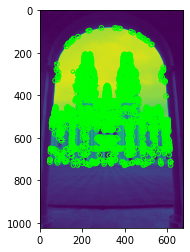

In [174]:
plt.imshow(img)
kp_plot = np.zeros_like(new_kps)
print(new_kps.shape)
kp_plot[:,0], kp_plot[:,1], kp_plot[:,2], kp_plot[:,3] = new_kps[:,0], new_kps[:,1], 6*new_kps[:,2], new_kps[:,3]
plotframes(kp_plot)
plt.show()